### This is the code to grid search some parameters to create an LSTM model
#### References:
- Peixeiro, M. (2022). Time series forecasting in Python. Manning. Includes the codes fromi its GitHub repo (https://github.com/marcopeix/AppliedTimeSeriesForecastingInPython). Contribution: The technique for converting the series into sequenced samples and the idea for scale and reeschale data after predictions.
- Discolll, N. (2024, January 12). Harnessing RNNs for Financial Time Series Analysis: A Python Approach. Medium. https://medium.com/@redeaddiscolll/harnessing-rnns-for-financial-time-series-analysis-a-python-approach-0669b3a25c7a. Contribution: EarlyStopping function.

#### Packages
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Package Tensorflow (2.16). (2024). [Python]. https://github.com/tensorflow

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random

import useful_functions as uf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1_l2
from tensorflow.random import set_seed

In [2]:
# load data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# define the target variable as the first column
target_variable = df_raw.columns[0]

# Convert all columns to float
df_raw = df_raw.astype('float64')

# Define thresholds for outliers removal
remove_outliers_threshold = np.nan
#remove_outliers_threshold = 0.20

In [3]:
# Effectively remove outliers
if not pd.isna(remove_outliers_threshold): # if any threshold is defined
    df_cleaned = uf.remove_outliers(df_raw.copy(), threshold=remove_outliers_threshold)
else: # if no threshold is defined, just copy the dataframe
    df_cleaned = df_raw.copy()

# After removing outliers, fill missing values
df_adjusted = uf.fill_missing_values(df_cleaned)

In [4]:
# Define test and validation set sizes
val_size = 48 # 48 months or 4 years
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets
train_raw_total = df_adjusted.copy()[:-test_size] # This total trainning set will be used to train the final model
train_raw = train_raw_total[:-val_size]
val_raw = train_raw_total[-val_size:]
test_raw = df_adjusted.copy()[-test_size:]

# Fill missing values
df_train = uf.fill_missing_values(train_raw)
df_val = uf.fill_missing_values(val_raw)
df_test = uf.fill_missing_values(test_raw)


In [5]:
# Let´s scale the variables to put all of them in the same range (0,1)
# Define the scaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train) # fit and transform the train set
scaled_val = scaler.transform(df_val) # transform the val set
scaled_test = scaler.transform(df_test) # transform the test set

# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_train.columns)
val = pd.DataFrame(scaled_val, columns=df_val.columns)
test = pd.DataFrame(scaled_test, columns=df_test.columns)

# Include the index in the train and test sets
train.index = df_train.index
val.index = df_val.index
test.index = df_test.index


Reshape your data

In [6]:
# Converting the series to samples
# We will use the past 12 months to predict a month 12 months in the future
def createXY(dataset, n_past, n_future):
    dataX, dataY = [], []
    # Loop for the entire dataset
    for i in range(n_past, len(dataset) - n_future + 1):
        dataX.append(dataset.iloc[i - n_past:i].values)  # Past n months
        dataY.append(dataset.iloc[i + n_future - 1, 0])  #
    return np.array(dataX), np.array(dataY)

n_past = 12  # Number of past months to use
n_future = 12  # future horizon to predict

# Create the samples
X_train, Y_train = createXY(train, n_past, n_future)
X_val, Y_val = createXY(val, n_past, n_future)
X_test, Y_test = createXY(test, n_past, n_future)


### Let's grid to find the best parameters

In [ ]:
# Let´s define the seed for reproducibility

def func_set_seed(seed=42):
    np.random.seed(seed)
    python_random.seed(seed)
    set_seed(seed) #tensorflow.random.set_seed(seed)

# Call the function to set the seed
func_set_seed(42)

In [7]:
### Build an LSTM model testing different parameters

# Function to build the model
def build_model(n_layers = 2, # Number of hidden layers
                optimizer='adam', # Optimizer
                learning_rate=0.001, # Learning rate used by the optimizer
                #alphas_l1_l2=0.01, # Removed because it didn't improve the model 
                lstm_units={0: 50,  1: 20, 2: 10}, # Number of units in the LSTM layers
                dropout_rate=0.2 # Dropout rate to avoid overfitting
                ):
    # Check the optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Create the model
    model = Sequential()
    # Define the input layer shape
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    # Add the LSTM layers
    for i in range(n_layers):
        return_sequences = i < n_layers - 1  # Only the last layer returns a single vector
        model.add(LSTM(units=lstm_units[i+1], # add layer according to the number of units
                       #kernel_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2), # Removed because it didn't improve the model
                       #recurrent_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                       #bias_regularizer=l1_l2(l1=alphas_l1_l2, l2=alphas_l1_l2),
                       return_sequences=return_sequences)) # If it's more than one layer, return the sequences
        model.add(Dropout(dropout_rate)) # Dropout layer to avoid overfitting
    model.add(Dense(units=1))  # Output layer
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Function to test each set of parameters
def custom_fit(params):
    training_params = {key: params[key] for key in params if key in ['n_layers', 
                                                                     #'alphas_l1_l2', # Decativated because it didn't improve the model.
                                                                     'dropout_rate',
                                                                     'lstm_units', 
                                                                     'optimizer', 
                                                                     'learning_rate']} # Use this to pass the parameters to the model
    model = build_model(**training_params) # Create the model
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True) # Stop training when the validation loss is no longer decreasing after X epochs

    # Fitting the model with early stopping
    model.fit(X_train, Y_train, 
              epochs=params['epochs'], # Number of epochs
              batch_size=params['batch_size'], # Batch size
              verbose=0, # Do not print the output
              validation_data=(X_val, Y_val), #
              callbacks=[early_stopping] # Include the early stopping callback
    )
    # Compute the loss on the validation set
    loss = model.evaluate(X_val, Y_val, verbose=0)
    return loss

# Parameters to test
param_grid = {
    'dropout_rate': [0.1, 0.2, 0.3],
    'alphas_l1_l2' : [0.001, 0.01, 0.1, 1],
    'batch_size': [32, 64, 128],
    'epochs': [20, 50, 75],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.0001], # Learning rate
    'n_layers': [1,2,3], # Number of hidden layers
    'lstm_units' : [{1: 10,  2: 10, 3: 5}, {1: 50,  2: 30, 3: 15}, 
                   {1: 100,  2: 100, 3: 50}, {1: 200,  2: 200, 3: 100}]  
}

# Compare the scores for each set of parameters
best_score = np.inf
best_params = None
interactions = 1
# test all the combinations of parameters
for params in ParameterGrid(param_grid): # for each set of parameters
    print("Applying parameters: ", params,". This is the ", interactions, "th iteration")
    interactions += 1
    score = custom_fit(params) # Compute the loss
    if score < best_score: # If the loss is better than the best score
        best_score = score # Update the best score
        best_params = params # Update the best parameters

# Print the best score and the best parameters
print(f'Best Score: {best_score}')
print(f'Best Parameters: {best_params}')

Applying parameters:  {'alphas_l1_l2': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': {1: 10, 2: 10, 3: 5}, 'n_layers': 1, 'optimizer': 'adam'} . This is the  1 th iteration
Applying parameters:  {'alphas_l1_l2': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': {1: 10, 2: 10, 3: 5}, 'n_layers': 1, 'optimizer': 'rmsprop'} . This is the  2 th iteration
Applying parameters:  {'alphas_l1_l2': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': {1: 10, 2: 10, 3: 5}, 'n_layers': 2, 'optimizer': 'adam'} . This is the  3 th iteration
Applying parameters:  {'alphas_l1_l2': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'learning_rate': 0.001, 'lstm_units': {1: 10, 2: 10, 3: 5}, 'n_layers': 2, 'optimizer': 'rmsprop'} . This is the  4 th iteration
Applying parameters:  {'alphas_l1_l2': 0.001, 'batch_size': 32, 'dropout_rate': 0.1, 'epochs':

In [71]:
# Now let's build the model with the best parameters and train it
# Get epochs and batch_size from best_params
best_params_bkp = best_params.copy()
epochs = best_params.pop('epochs')
batch_size = best_params.pop('batch_size')

# build the model
best_model = build_model(**best_params)

In [73]:
# Save the best model - Adjust the file name based on the dataset used and the patience of the early stopping
best_model.save('best_lstm_model_grid_ori_6.keras')  # Saves the model to a keras file

In [ ]:
# If we need to restore the best model

# # Load the model from the file
# best_model = load_model('best_lstm_model_grid.keras')
# # from manual hyperparameter tuning
# epochs = 20
# batch_size = 32



In [ ]:
# train the model with the best parameters
history = best_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=0)

# Make predictions on the validation set
predictions_scaled = best_model.predict(X_val)

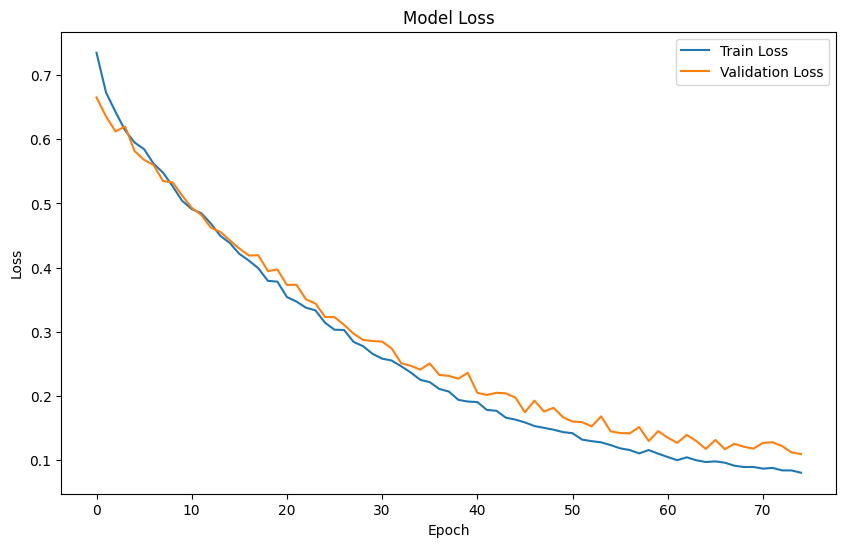

In [75]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [76]:
# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_scaled_2d = predictions_scaled.reshape(-1, 1)

# Get the last timestep of X_val
X_val_last_timestep = X_val[:, -1, :]

# Replace the first column of X_val_last_timestep with the scaled predictions.
X_val_last_timestep[:, 0] = predictions_scaled_2d[:, 0]

# unscale the predictions
predictions_rescaled = scaler.inverse_transform(X_val_last_timestep)[:, 0]

# unscale the Y_val
Y_val_rescaled = scaler.inverse_transform(val.iloc[-len(predictions_scaled):, :].values)[:, 0]

# Calculate the error
mape_LSTM_val = mean_absolute_percentage_error(Y_val_rescaled, predictions_rescaled)
rmse_LSTM_val = np.sqrt(mean_squared_error(Y_val_rescaled, predictions_rescaled))
mae_LSTM_val = mean_absolute_error(Y_val_rescaled, predictions_rescaled)

print(f'MAPE LSTM: {mape_LSTM_val}')
print(f'RMSE LSTM: {rmse_LSTM_val}')
print(f'MAE LSTM: {mae_LSTM_val}')

MAPE LSTM: 1.6154865026474
RMSE LSTM: 19772.81640625
MAE LSTM: 12819.42578125


In [78]:
# Let's predict the test set using the best model
predictions_test_scaled = best_model.predict(X_test)

# Let's reshape the predictions and Y_val to revert the scaling
# Reshape predictions to 2D
predictions_test_scaled_2d = predictions_test_scaled.reshape(-1, 1)

# Get the last timestep of X_test
X_test_last_timestep = X_test[:, -1, :]

# Replace the first column of X_test_last_timestep with the scaled predictions.
X_test_last_timestep[:, 0] = predictions_test_scaled_2d[:, 0]

# unscale the predictions
predictions_test_rescaled = scaler.inverse_transform(X_test_last_timestep)[:, 0]

# Let's convert the predictions and Y_test to a dataframe usind the index from test
predictions_test_df = pd.DataFrame(predictions_test_rescaled, index=test.index[-len(predictions_test_rescaled):], columns=[target_variable])
predictions = predictions_test_df.copy()

# Get the original Y_test values
Y_test = df_adjusted[-len(predictions):][target_variable]


In [79]:
# Calculate the error
mape_best_LSTM = mean_absolute_percentage_error(Y_test, predictions)
rmse_best_LSTM = np.sqrt(mean_squared_error(Y_test, predictions))
mae_best_LSTM = mean_absolute_error(Y_test, predictions)

print(f'MAPE best LSTM: {mape_best_LSTM}')
print(f'RMSE best LSTM: {rmse_best_LSTM}')
print(f'MAE best LSTM: {mae_best_LSTM}')

MAPE best LSTM: 1.1143759489059448
RMSE best LSTM: 43350.359375
MAE best LSTM: 33338.4609375


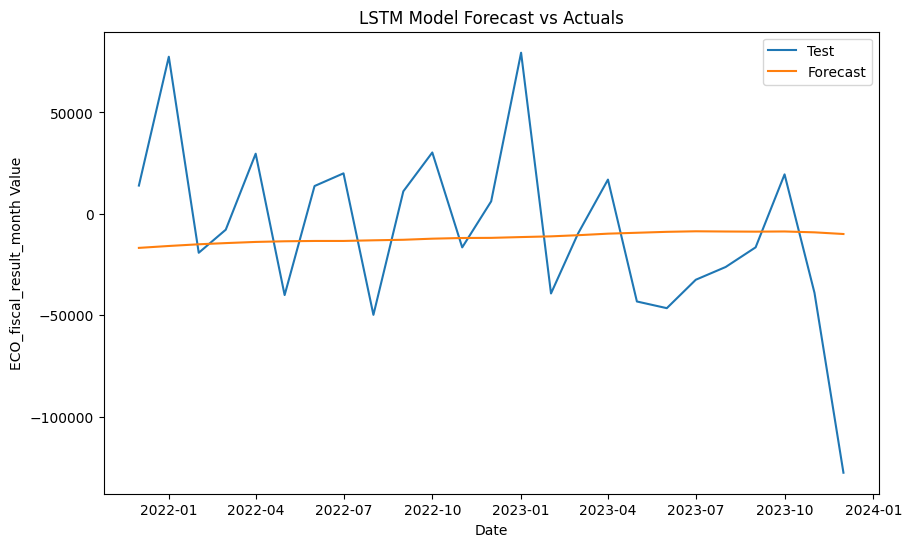

In [80]:
# Plot LSTM best Model Forecast(static) vs Actuals

# Convert Y_test_rescaled to a dataframe using the test index
Y_test_rescaled_df = pd.DataFrame(Y_test, index=Y_test.index)
# Change the column name to the target variable
Y_test_rescaled_df.columns = [target_variable]

# Plot the forecast using useful_functions 
uf.plot_prediction_vs_test(
    target_variable, 
    Y_test_rescaled_df[target_variable],
    predictions,
    'LSTM Model Predictions vs Actuals - Test Set')